In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequence.kernel.timeline import Timeline
from sequence.topology.node import Node
from sequence.components.wave_plate import WavePlate
from sequence.components.spdc_source_node import SpdcSourceNode
from sequence.components.optical_channel import QuantumChannel
from sequence.components.photon import Photon

In [2]:
class Receiver(Node):
    def __init__(self, name, timeline):
        super().__init__(name, timeline)
        self.log = []

    def receive_qubit(self, src, qubit):
        self.log.append((self.timeline.now(), src, qubit))
        
class MiddleNode(Node):
    def __init__(self, name, timeline, wp):
        super().__init__(name, timeline)
        self.wp = wp
        self.wp.owner = self
        self.last_qubit_state = None

    def receive_qubit(self, src, qubit):
        self.wp.get(qubit)
        self.last_qubit_state = qubit.quantum_state.state

    def get(self, photon: "Photon", **kwargs):
        for index, dst in enumerate(self.qchannels):
            self.send_qubit(dst, photon)

def run_for_angle(angle_rad):
    tl = Timeline()
    source = SpdcSourceNode("source", tl, config={
        "frequency": 1e6,
        "mean_photon_num": 0.1,
        "bell_state": "psi+"
    })

    wp = WavePlate("wp", tl, plate_type="HWP", angle=angle_rad)
    middle = MiddleNode("middle", tl, wp)
    receiver = Receiver("receiver", tl)
    wp.add_receiver(middle)


    # Create quantum channels from source to middle and middle to receiver
    qc0 = QuantumChannel("qc0", tl, distance=1e5, attenuation=0)
    qc1 = QuantumChannel("qc1", tl, distance=1e5, attenuation=0)
    qc0.set_ends(source, middle.name)
    qc1.set_ends(middle, receiver.name)

    tl.init()
    source.spdc.emit(num_pulses=100)
    tl.run()

    return np.abs(middle.last_qubit_state)

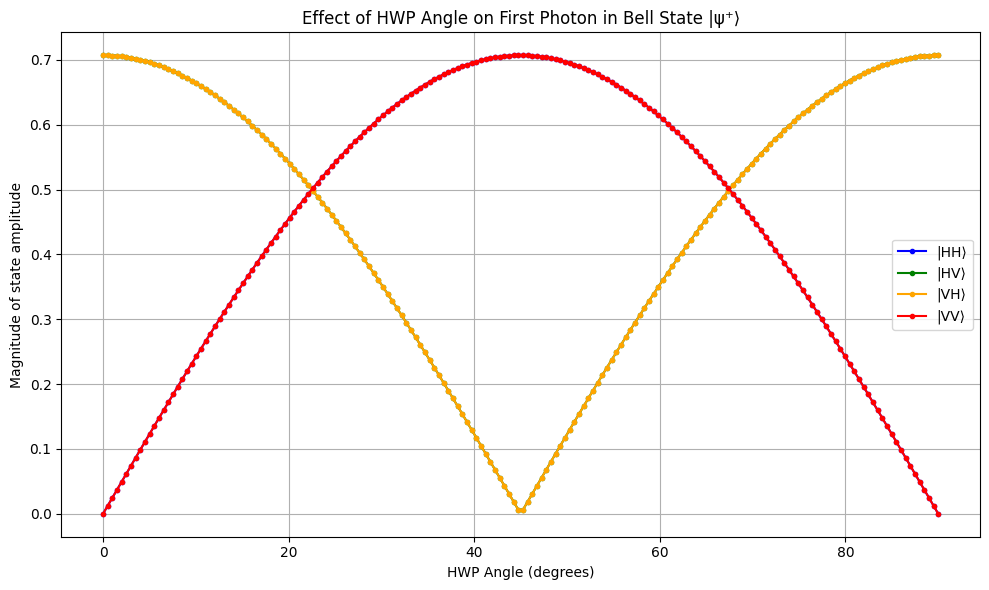

In [3]:
# Sweep over angles from 0° to 90°
angles_deg = np.linspace(0, 90, 180)
angles_rad = np.deg2rad(angles_deg)

# Store magnitude of each 4-dimensional state component: [HH, HV, VH, VV]
magnitudes = [[], [], [], []]

for angle in angles_rad:
    state_mag = run_for_angle(angle)
    for i in range(4):
        magnitudes[i].append(state_mag[i])

# Plot
labels = ["|HH⟩", "|HV⟩", "|VH⟩", "|VV⟩"]
colors = ["blue", "green", "orange", "red"]
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(angles_deg, magnitudes[i], label=labels[i], color=colors[i], marker='.')

plt.xlabel("HWP Angle (degrees)")
plt.ylabel("Magnitude of state amplitude")
plt.title("Effect of HWP Angle on First Photon in Bell State |ψ⁺⟩")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()